In [2]:
#---------------------------------------------------
# LANGKAH 0: IMPORT LIBRARY DAN HUBUNGKAN GOOGLE DRIVE
#---------------------------------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

# Hubungkan notebook ke Google Drive Anda
from google.colab import drive
drive.mount('/content/drive')

print("TensorFlow Version:", tf.__version__)

Mounted at /content/drive
TensorFlow Version: 2.18.0


In [3]:
#---------------------------------------------------
# LANGKAH 1: PENDEFINISIAN PATH DAN PARAMETER
#---------------------------------------------------
# PASTIKAN PATH INI SESUAI DENGAN STRUKTUR DI DRIVE ANDA!
base_dir = '/content/drive/MyDrive/Dataset Deep Learning Kelompok'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
pred_dir = os.path.join(base_dir, 'pred')

# Parameter untuk model dan data
IMG_SIZE = (128, 128) # Ukuran gambar yang akan dimasukkan ke model
BATCH_SIZE = 32      # Jumlah gambar yang diproses dalam satu waktu
EPOCHS = 20          # Berapa kali model akan melihat keseluruhan dataset

In [4]:
#---------------------------------------------------
# LANGKAH 2: PERSIAPAN DATA (ImageDataGenerator)
#---------------------------------------------------
# Membuat generator untuk data training dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalisasi piksel ke [0, 1]
    rotation_range=20,          # Rotasi acak
    width_shift_range=0.2,      # Geser horizontal
    height_shift_range=0.2,     # Geser vertikal
    shear_range=0.2,            # Miringkan gambar
    zoom_range=0.2,             # Zoom acak
    fill_mode='nearest'
)

# Membuat generator untuk data validasi (tanpa augmentasi, hanya normalisasi)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Memuat data dari direktori menggunakan generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical' # Untuk klasifikasi multikelas
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Mendapatkan jumlah kelas dari generator
num_classes = len(train_generator.class_indices)
print(f"\nBerhasil memuat data. Ditemukan {num_classes} kelas.")
print("Indeks Kelas:", train_generator.class_indices)


Found 1850 images belonging to 23 classes.
Found 460 images belonging to 23 classes.

Berhasil memuat data. Ditemukan 23 kelas.
Indeks Kelas: {'a': 0, 'ba': 1, 'ca': 2, 'da': 3, 'ga': 4, 'ha': 5, 'ja': 6, 'ka': 7, 'la': 8, 'ma': 9, 'mpa': 10, 'na': 11, 'nca': 12, 'nga': 13, 'ngka': 14, 'nra': 15, 'nya': 16, 'pa': 17, 'ra': 18, 'sa': 19, 'ta': 20, 'wa': 21, 'ya': 22}


In [5]:
#---------------------------------------------------
# LANGKAH 3: MEMBANGUN MODEL (TRANSFER LEARNING)
#---------------------------------------------------
# Muat model dasar MobileNetV2 yang sudah terlatih
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,), # Ukuran gambar + 3 channel warna (RGB)
    include_top=False,           # Hapus lapisan klasifikasi teratas
    weights='imagenet'
)

# Bekukan (freeze) semua lapisan di model dasar agar tidak ikut terlatih
base_model.trainable = False

# Buat lapisan klasifikasi baru (kepala model)
x = base_model.output
x = GlobalAveragePooling2D()(x) # Mengubah output menjadi vektor fitur
x = Dropout(0.5)(x)             # Dropout untuk mengurangi overfitting
# Lapisan output dengan jumlah neuron sesuai jumlah kelas dan aktivasi softmax
outputs = Dense(num_classes, activation='softmax')(x)

# Gabungkan model dasar dengan kepala yang baru
model = Model(inputs=base_model.input, outputs=outputs)

# Tampilkan arsitektur model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,287,447 (8.73 MB)

 Trainable params: 29,463 (115.09 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
#---------------------------------------------------
# LANGKAH 4: KOMPILASI DAN LATIH MODEL
#---------------------------------------------------
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nMemulai proses training...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1 # Tampilkan progress bar
)
print("Training selesai.")


Memulai proses training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.1680 - loss: 3.2398 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 886s 15s/step - accuracy: 0.1704 - loss: 3.2265 - val_accuracy: 0.6957 - val_loss: 1.2743
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - accuracy: 0.6207 - loss: 1.2453 - val_accuracy: 0.7761 - val_loss: 0.9117
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - accuracy: 0.7581 - loss: 0.7807 - val_accuracy: 0.8022 - val_loss: 0.7979
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - accuracy: 0.8577 - loss: 0.5038 - val_accuracy: 0.8109 - val_loss: 0.7059
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 257ms/step - accuracy: 0.8894 - loss: 0.4324 - val_accuracy: 0.8196 - val_loss: 0.7075
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - accuracy: 0.8975 - loss: 0.3586 - val_accuracy: 0.8261 - val_loss: 0.7142
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 253ms/step - accuracy: 0.9105 - loss: 0.3028 - val_accuracy: 0.8348 - val_loss: 0.6538
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - accuracy: 0.9191 - loss: 0.2809 - val_accuracy: 0.8370

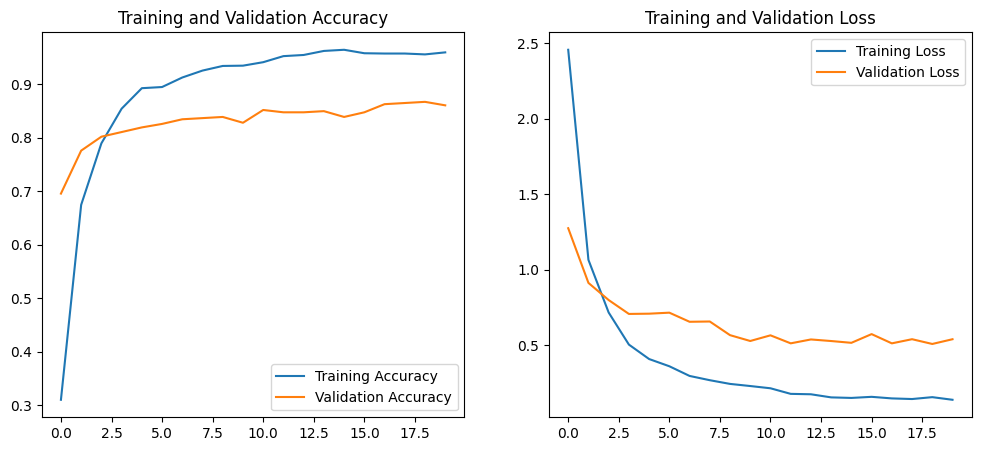


Evaluasi akhir pada data validasi:
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.8712 - loss: 0.4535
Validation Loss: 0.5381
Validation Accuracy: 86.09%


In [7]:
#---------------------------------------------------
# LANGKAH 5: EVALUASI MODEL
#---------------------------------------------------
# Plot akurasi dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluasi akhir pada data validasi
print("\nEvaluasi akhir pada data validasi:")
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")


Model berhasil disimpan di: /content/drive/MyDrive/lontara_classifier_model.h5



Model berhasil dimuat kembali.

Melakukan prediksi pada gambar: /content/drive/MyDrive/Dataset Deep Learning Kelompok/pred/Scan_20220523 (7)53rm10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


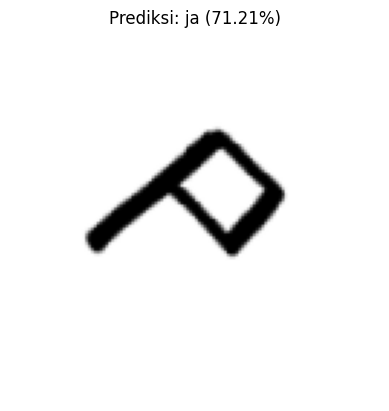

In [8]:
#-----------------------------------------------------------
# LANGKAH 6: DEPLOYMENT (SIMPAN MODEL & GUNAKAN UNTUK PREDIKSI)
#-----------------------------------------------------------

# 6.1. Menyimpan Model
# Simpan model ke dalam satu file format HDF5 (.h5)
model_save_path = '/content/drive/MyDrive/lontara_classifier_model.h5'
model.save(model_save_path)
print(f"\nModel berhasil disimpan di: {model_save_path}")

# 6.2. Memuat Model (Simulasi penggunaan di aplikasi lain)
loaded_model = tf.keras.models.load_model(model_save_path)
print("\nModel berhasil dimuat kembali.")

# 6.3. Melakukan Prediksi pada Gambar Baru
# Ambil satu contoh gambar dari folder 'pred'
# Ganti 'contoh_prediksi.png' dengan nama file gambar Anda di folder 'pred'
try:
    pred_image_name = os.listdir(pred_dir)[0] # Ambil gambar pertama di folder pred
    image_path = os.path.join(pred_dir, pred_image_name)

    print(f"\nMelakukan prediksi pada gambar: {image_path}")

    # Muat dan siapkan gambar untuk prediksi
    img = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Buat batch
    img_array /= 255.0 # Normalisasi piksel

    # Lakukan prediksi
    predictions = loaded_model.predict(img_array)
    predicted_score = np.max(predictions[0])
    predicted_index = np.argmax(predictions[0])

    # Dapatkan nama kelas dari indeks
    class_labels = list(train_generator.class_indices.keys())
    predicted_class = class_labels[predicted_index]

    # Tampilkan hasil
    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_class} ({predicted_score*100:.2f}%)")
    plt.axis('off')
    plt.show()

except IndexError:
    print(f"\nTidak dapat menemukan gambar di folder 'pred'. Pastikan ada file gambar di '{pred_dir}'")
except Exception as e:
    print(f"\nTerjadi error saat prediksi: {e}")
